---
title: "Compare Averages (relmax3)"
author: "Laura Vairus"
date: "2023-07-19"
---

## Import Libraries

In [3]:
# import packages
import tensorflow as tf
# Make sure the GPU is enabled 
#assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow_hub as hub # for interacting with saved models and tensorflow hub
import joblib
import gzip # for manipulating compressed files
import kipoiseq # for manipulating fasta files
from kipoiseq import Interval # same as above, really
import pyfaidx # to index our reference genome file
import pandas as pd # for manipulating dataframes
import numpy as np # for numerical computations
import matplotlib.pyplot as plt # for plotting
import matplotlib as mpl # for plotting
import seaborn as sns # for plotting
import pickle # for saving large objects
import os, sys # functions for interacting with the operating system

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2023-07-19 21:57:25.871503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 21:57:32.441866: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/nvidia/hpc_sdk/Linux_x86_64/21.9/comm_libs/nvshmeme/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/21.9/comm_libs/nccl/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/21.9/math_libs/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/21.9/compilers/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/21.9/compilersextras/qd/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/21.9/cudaextras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64

AssertionError: Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU

## Define Paths

In [7]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/grand/TFXcan/imlab/users/lvairus/hackenf/data/genome.fa'
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')

## Define Functions

In [10]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)


class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.


# @title `variant_centered_sequences`

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}
    #import pd.Interval as Interval
    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)



# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

In [11]:
import Bio

from Bio.Seq import Seq
def create_rev_complement(dna_string):
    return(str(Seq(dna_string).reverse_complement()))

In [12]:
def prepare_for_quantify_prediction_per_TSS(predictions, gene, tss_df):

  '''

  Parameters:
          predicitions (A numpy array): All predictions from the track
          gene (a gene name, character): a gene
          tss_df: a list of dataframe of genes and their transcription start sites
  Returns:
          A dictionary of cage experiment predictions and a list of transcription start sites

  '''

  output = dict()
  for tdf in tss_df:
    if gene not in tdf.genes.values:
      continue
    gene_tss_list = tdf[tdf.genes == gene].txStart_Sites.apply(str).values
    gene_tss_list = [t.split(', ') for t in gene_tss_list]
    gene_tss_list = [int(item) for nestedlist in gene_tss_list for item in nestedlist]
    gene_tss_list = list(set(gene_tss_list))
  output['cage_predictions'] = predictions[:, 5110] # a numpy array
  output['gene_TSS'] = gene_tss_list # a list


  return(output) # a dictionary

def quantify_prediction_per_TSS(low_range, TSS, cage_predictions):

  '''
  Parameters:
          low_range (int): The lower interval
          TSS (list of integers): A list of TSS for a gene
          cage_predictions: A 1D numpy array or a vector of predictions from enformer corresponding to track 5110 or CAGE predictions
  Returns:
          A dictionary of gene expression predictions for each TSS for a gene
    '''
  tss_predictions = dict()
  for tss in TSS:
    bin_start = low_range + ((768 + 320) * 128)
    count = -1
    while bin_start < tss:
      bin_start = bin_start + 128
      count += 1
    if count >= len(cage_predictions)-1:
      continue
    cage_preds = cage_predictions[count - 1] + cage_predictions[count] + cage_predictions[count + 1]
    tss_predictions[tss] = cage_preds

  return(tss_predictions)

def collect_intervals(chromosomes = ["22"], gene_list=None):

  '''
    Parameters :
      chromosomes : a list of chromosome numbers; each element should be a string format
      gene_list : a list of genes; the genes should be located on those chromosomes

    Returns :
      A dictionary of genes (from gene_list) and their intervals within their respective chromosomes
  '''

  gene_intervals = {} # Collect intervals for our genes of interest

  for chrom in chromosomes:
    with open("/grand/TFXcan/imlab/users/lvairus/hackenf/data/gene_chroms/gene_"+ chrom + ".txt", "r") as chrom_genes:
      for line in chrom_genes:
        split_line = line.strip().split("\t")
        gene_intervals[split_line[2]] = [
                                          split_line[0],
                                          int(split_line[3]),
                                          int(split_line[4])
                                        ]

  if isinstance(gene_list, list): # if the user has supplied a list of genes they are interested in
    use_genes = dict((k, gene_intervals[k]) for k in gene_list if k in gene_intervals)
    return(use_genes)
  elif isinstance(gene_list, type(None)):
    return(gene_intervals)


def run_predictions(gene_intervals, tss_dataframe, individuals_list=None):
  '''
  Parameters :
    gene_intervals : the results from calling `collect_intervals`
    tss_dataframe : a list of the TSSs dataframes i.e. the TSS for the genes in the chromosomes
    individuals_list : a list of individuals on which we want to make predictions; defaults to None

  Returns :
    A list of predictions; the first element is the predictions around the TSS for each gene. The second is the prediction across CAGE tracks
  '''

  gene_output = dict()
  gene_predictions = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2]) # creates an interval to select the right sequences
    target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))  # extracts the fasta sequences, and resizes such that it is compatible with the sequence_length
    window_coords = target_interval.resize(SEQUENCE_LENGTH) # we also need information about the start and end locations after resizing
    try:
      cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene
    except:
      continue
    individual_results = dict()
    individual_prediction = dict()

    if isinstance(individuals_list, list) or isinstance(individuals_list, type(np.empty([1, 1]))):
      use_individuals = individuals_list
    elif isinstance(individuals_list, type(None)):
      use_individuals = cur_gene_vars.columns[4:]

    for individual in use_individuals:
      print('Currently on gene {}, and predicting on individual {}...'.format(gene, individual))
      # two haplotypes per individual
      haplo_1 = list(target_fa[:])
      haplo_2 = list(target_fa[:])

      ref_mismatch_count = 0
      for i,row in cur_gene_vars.iterrows():

        geno = row[individual].split("|")
        if (row["POS"]-window_coords.start-1) >= len(haplo_2):
          continue
        if (row["POS"]-window_coords.start-1) < 0:
          continue
        if geno[0] == "1":
          haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
        if geno[1] == "1":
          haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]

      # predict on the individual's two haplotypes
      prediction_1 = model.predict_on_batch(one_hot_encode("".join(haplo_1))[np.newaxis])['human'][0]
      prediction_2 = model.predict_on_batch(one_hot_encode("".join(haplo_2))[np.newaxis])['human'][0]

      temp_predictions = [prediction_1[:, 5110], prediction_2[:, 5110]] # CAGE predictions we are interested in
      individual_prediction[individual] = temp_predictions

      # Calculate TSS CAGE expression which correspond to column 5110 of the predictions above
      temp_list = list()

      pred_prepared_1 = prepare_for_quantify_prediction_per_TSS(predictions=prediction_1, gene=gene, tss_df=tss_dataframe)
      tss_predictions_1 = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_prepared_1['gene_TSS'], cage_predictions=pred_prepared_1['cage_predictions'])

      pred_prepared_2 = prepare_for_quantify_prediction_per_TSS(predictions=prediction_2, gene=gene, tss_df=tss_dataframe)
      tss_predictions_2 = quantify_prediction_per_TSS(low_range = window_coords.start, TSS=pred_prepared_2['gene_TSS'], cage_predictions=pred_prepared_2['cage_predictions'])

      temp_list.append(tss_predictions_1)
      temp_list.append(tss_predictions_2) # results here are a dictionary for each TSS for each haplotype

      individual_results[individual] = temp_list # save for the individual

    gene_output[gene] = individual_results
    gene_predictions[gene] = individual_prediction

  return([gene_output, gene_predictions])


def collect_target_intervals(gene_intervals):

  '''
  Returns a dictionary of Interval objects (from kipoiseq) for each gene corresponding to the locations of the gene
  '''

  target_intervals_dict = dict()

  for gene in gene_intervals.keys():
    gene_interval = gene_intervals[gene]
    target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2])
    target_intervals_dict[gene] = target_interval

  return(target_intervals_dict)

def prepare_for_plot_tracks(gene, individual, all_predictions, chromosome=['22']):

  '''
  This returns a dictionary of gene tracks and gene intervals, prepared for the function plot_tracks.

  Parameters:
    - gene
    - individual
    - all_predictions
  '''

  haplo_predictions = all_predictions[gene][individual]
  gene_tracks = {gene + ' | ' + individual + ' | haplotype 1': np.log10(1 + haplo_predictions[0]),
                gene + ' | ' + individual + ' | haplotype 2': np.log10(1 + haplo_predictions[1])}

  gene_intervals = collect_intervals(chromosomes=chromosome, gene_list=[gene])
  gene_intervals = collect_target_intervals(gene_intervals)

  output = dict()
  output['gene_tracks'] = gene_tracks
  output['gene_intervals'] = gene_intervals[gene]

  return(output)

def check_individuals(path_to_bed_file, list_of_individuals):

  '''
  Checks if an individual is missing in bed variation files.
  These individuals should be removed prior to training
  '''

  myfile = open(path_to_bed_file, 'r')
  myline = myfile.readline()
  bed_names = myline.split('\t')[4:]
  myfile.close()

  if set(list_of_individuals).issubset(set(bed_names)) == False:
    missing = list(set(list_of_individuals).difference(bed_names))
    print('This (or these) individual(s) is/are not present: {}'.format(missing))
  else:
    missing = []
    print('All individuals are present in the bed file.')

  return(missing)

In [13]:
def geno_to_seq(gene, individual):
      # two haplotypes per individual
  haplo_1 = list(target_fa[:])
  haplo_2 = list(target_fa[:])

  ref_mismatch_count = 0
  for i,row in cur_gene_vars.iterrows():

    geno = row[individual].split("|")
    if (row["POS"]-window_coords.start-1) >= len(haplo_2):
      continue
    if (row["POS"]-window_coords.start-1) < 0:
      continue
    if geno[0] == "1":
      haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
    if geno[1] == "1":
      haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]
  return haplo_1, haplo_2

      # predict on the individual's two haplotypes
    

In [14]:
def run_predictions2(gene, chrom, indiv):
    '''
    Parameters :
       gene: gene to run (string)
       chrom: chrom gene is on (string)
       indiv: individual to run (string)
       chrNtss: variable of tss for chr
    Returns :
        A list of predictions; the first element is the predictions around the TSS for each gene. The second is the prediction across CAGE tracks
    '''
    
    gene_intervals = collect_intervals(chromosomes=[chrom], gene_list=[gene])
    individuals_list = [indiv]

    for gene in gene_intervals.keys():
        global fasta_extractor
        gene_interval = gene_intervals[gene]
        target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                            gene_interval[1],
                                            gene_interval[2]) # creates an interval to select the right sequences
        target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))  # extracts the fasta sequences, and resizes such that it is compatible with the sequence_length
        window_coords = target_interval.resize(SEQUENCE_LENGTH) # we also need information about the start and end locations after resizing
        try:
            cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene
        except:
            continue
        individual_prediction = dict()

        if isinstance(individuals_list, list) or isinstance(individuals_list, type(np.empty([1, 1]))):
            use_individuals = individuals_list
        elif isinstance(individuals_list, type(None)):
            use_individuals = cur_gene_vars.columns[4:]

        for individual in use_individuals:
            # two haplotypes per individual
            haplo_1 = list(target_fa[:])
            haplo_2 = list(target_fa[:])

            ref_mismatch_count = 0
            for i,row in cur_gene_vars.iterrows():

                geno = row[individual].split("|")
                if (row["POS"]-window_coords.start-1) >= len(haplo_2):
                    continue
                if (row["POS"]-window_coords.start-1) < 0:
                    continue
                if geno[0] == "1":
                    haplo_1[row["POS"]-window_coords.start-1] = row["ALT"]
                if geno[1] == "1":
                    haplo_2[row["POS"]-window_coords.start-1] = row["ALT"]

            # predict on the individual's two haplotypes
            global model

            ohe_haplo_1 = one_hot_encode("".join(haplo_1))[np.newaxis]
            ohe_haplo_2 = one_hot_encode("".join(haplo_2))[np.newaxis]

            ohe_haplo_avg = np.add(ohe_haplo_1, ohe_haplo_2) / 2
                                         
            prediction_1 = model.predict_on_batch(ohe_haplo_1)['human'][0]
            prediction_2 = model.predict_on_batch(ohe_haplo_2)['human'][0]
            prediction_avg = model.predict_on_batch(ohe_haplo_avg)['human'][0]
            
            post_avg = (prediction_1 + prediction_2) / 2
            pre_avg = prediction_avg

    return([pre_avg, post_avg])

In [37]:
# rel diff helper functions

def get_relmax(arr):
    arr = np.abs(arr)
    col_max = np.max(arr, axis=0)
    relmax = arr / col_max
    return relmax

def get_rel99(arr):
    arr = np.abs(arr)
    col_99 = np.percentile(arr, 99.9, axis=0)
    rel99 = arr / col_99
    return rel99

def get_relmed(arr):
    arr = np.abs(arr)
    col_med = np.median(arr, axis=0)
    relmed = arr / col_med
    return relmed

def get_rel_ppavg(pre, post):
    


In [110]:
# Comparison functions

def get_diffmats(mat1, mat2):
    # make diffmats
    diffmat = mat1 - mat2
    abs_diffmat = np.abs(diffmat)
    # rel_diffmat = abs_diffmat / (np.abs(pre_avg) + np.abs(post_avg) + 1**-16)
    # relmax_diffmat = get_relmax(abs_diffmat) 
    # relmed_diffmat = get_relmed(abs_diffmat) 
    # rel95_diffmat = get_rel99(abs_diffmat)

    # new diff mat
    mat1_colwise_maxes = np.max(mat1, axis=0)
    mat2_colwise_maxes = np.max(mat2, axis=0)

    tot_colwise_maxes = np.maximum(mat1_colwise_maxes, mat2_colwise_maxes)

    relmax3_diffmat = diffmat / tot_colwise_maxes

    return relmax3_diffmat

    #return (abs_diffmat, rel_diffmat, relmax_diffmat, relmed_diffmat, rel95_diffmat)


def get_summary(arr):
    """
    input: any np array 
    output: dict of its mean, median, std_dev, min, max, total sum, q1, q3, and iqr
    """
    summary = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std_dev": np.std(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "total_sum": np.sum(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
        "iqr": np.percentile(arr, 75) - np.percentile(arr, 25)
    }
    return summary


def get_colwise_summary_df(arr):
    """
    input: a 2+ dim np array 
    output: summary of every column as a pd dataframe
    """
    # Initialize empty dictionary
    col_summaries = {}
    # Compute summary statistics for each column and store in dictionary
    for col_index in range(arr.shape[1]):
        col_name = col_index
        col_data = arr[:, col_index]
        col_summary = get_summary(col_data)
        col_summaries[col_name] = col_summary
    # Convert dictionary to DataFrame
    col_summaries_df = pd.DataFrame(col_summaries).transpose()

    return col_summaries_df


def plot_tols_vs_outs(arr, mintol, maxtol, steps):
    """
    Plots tolerance vs percentage of outliers for a np array

    Parameters:
    arr (np array): array you're interested in
    mintol (int): minimum tolerance you want
    maxtol (int): maximum tolerance you want
    steps (int): amount of points you want plotted between your min and max tolerances

    Returns:
    None
    """
    # make x and y values
    x = np.linspace(maxtol, mintol, steps)
    y = []
    for tol in x:
        num_outs = len(get_outliers(arr, tol))
        out_perc = num_outs/arr.size
        print(f'tolerance: {round(tol, 2)}, num outs: {num_outs}, out percent: {out_perc}')
        y.append(out_perc)
    # plot x and y
    plt.scatter(x, y)
    plt.xlabel('tolerance')
    plt.ylabel('percentage of outliers')
    plt.show()

    return None


def get_outliers(arr, tol):
    """
    returns every value of a np array that is above a specified tolerance

    Parameters:
    arr (np array): array you're interested in
    tol (int): max value you tolerate, anything above this is considered an outlier

    Returns:
    a np array of every value above the tolerance
    """
    outs = arr[arr > tol]

    return outs


def get_outlier_inds(arr, tol):
    """
    returns the index of every value of a np array that is above a specified tolerance

    Parameters:
    arr (np array): array you're interested in
    tol (int): max value you tolerate, anything above this is considered an outlier

    Returns:
    a list of 0: a list of tuples of indicies, 1: a list of row indices, and 2: a list of column indicies, of every value above the tolerance
    """
    # get list of ind tuples
    out_inds = np.where(arr > tol)
    out_inds_arr = np.array(list(zip(out_inds[0], out_inds[1])))
    # get list of row and col inds
    row_inds = out_inds[0]
    col_inds = out_inds[1]

    return [out_inds_arr, row_inds, col_inds]


def plot_hist(arr, bin_num, xlab='Value', ylab='Frequency', title='Histogram'):
    """
    plots a histogram of any np array

    Parameters:
    arr (np array): array you're interested in
    bin_num (int): amount of bins you want plotted
    xlab (str): x-axis label
    ylab (str): y-axis label
    title (str): title label

    Returns:
    None
    """
    plt.hist(arr, bins=bin_num)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

    return None


def make_outs_df(arr, tol):
    # get outliers and their inds
    outs = get_outliers(arr, tol)
    all_inds, row_inds, col_inds = get_outlier_inds(arr, tol)
    # make data
    data = {
        'name': df_targets['description'].iloc[col_inds],
        'bin': row_inds,
        'diff': outs,
        'system_slims': df_targets['system_slims'].iloc[col_inds],
        'cell_slims': df_targets['cell_slims'].iloc[col_inds],
        'organ_slims': df_targets['organ_slims'].iloc[col_inds],
        'developmental_slims': df_targets['developmental_slims'].iloc[col_inds]
    }
    # make df
    df = pd.DataFrame(data)
    # sort by ascending difference
    df_sorted = df.sort_values('diff')

    return df_sorted


def get_system_info(df):
    # df must be from from make_outs_df
    # prints a histogram of system counts
    # outputs a tuple of the full system list and a dictionary of their counts

    # make list of all systems and expand them
    sys_compressed = df['system_slims'].tolist()
    sys_expanded = []
    for sys in sys_compressed:
        if type(sys) == float:
            continue
        sys_list = sys.split(", ")
        sys_expanded += sys_list

    # get counts of every system
    sys_counts = Counter(sys_expanded)
    sys_counts_sorted = dict(sorted(sys_counts.items(), key=lambda item: item[1], reverse=True))
    
    # plot bar graph of systems
    keys = sys_counts_sorted.keys()
    values = sys_counts_sorted.values()
    plt.bar(keys, values)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('System')
    plt.ylabel('Count')
    plt.title('System Counts')
    plt.show()

    return (sys_expanded, sys_counts_sorted)


def get_cell_info(df):
    # df must be from from make_outs_df
    # prints a histogram of cell counts
    # outputs a tuple of the full cell list and a dictionary of their counts

    # make list of all cells and expand them
    cell_compressed = df['cell_slims'].tolist()
    cell_expanded = []
    for cell in cell_compressed:
        if type(cell) == float:
            continue
        cell_list = cell.split(", ")
        cell_expanded += cell_list

    # get counts of every cell
    cell_counts = Counter(cell_expanded)
    cell_counts_sorted = dict(sorted(cell_counts.items(), key=lambda item: item[1], reverse=True))

    # plot bar graph of cells
    keys = cell_counts_sorted.keys()
    values = cell_counts_sorted.values()
    plt.bar(keys, values)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('Cell')
    plt.ylabel('Count')
    plt.title('Cell Counts')
    plt.show()

    return (cell_expanded, cell_counts_sorted)


def get_organ_info(df):
    # input df must be from from make_outs_df
    # prints a histogram of organ counts
    # outputs a tuple of the full organ list and a dictionary of their counts

    # make list of all organs and expand them
    organ_compressed = df['organ_slims'].tolist()
    organ_expanded = []
    for organ in organ_compressed:
        if type(organ) == float:
            continue
        organ_list = organ.split(", ")
        organ_expanded += organ_list

    # get counts of every organ
    organ_counts = Counter(organ_expanded)
    organ_counts_sorted = dict(sorted(organ_counts.items(), key=lambda item: item[1], reverse=True))

    # plot bar graph of organs
    keys = organ_counts_sorted.keys()
    values = organ_counts_sorted.values()
    plt.bar(keys, values)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('Organ')
    plt.ylabel('Count')
    plt.title('Organ Counts')
    plt.show()

    return (organ_expanded, organ_counts_sorted)


def get_developmental_info(df):
    # df must be from from make_outs_df
    # prints a histogram of developmental stage counts
    # outputs a tuple of the full developmental stage list and a dictionary of their counts

    # make list of all developmental stages and expand them
    developmental_compressed = df['developmental_slims'].tolist()
    developmental_expanded = []
    for developmental in developmental_compressed:
        if type(developmental) == float:
            continue
        developmental_list = developmental.split(", ")
        developmental_expanded += developmental_list

    # get counts of every developmental stage
    developmental_counts = Counter(developmental_expanded)
    developmental_counts_sorted = dict(sorted(developmental_counts.items(), key=lambda item: item[1], reverse=True))

    # plot bar graph of developmental stages
    keys = developmental_counts_sorted.keys()
    values = developmental_counts_sorted.values()
    plt.bar(keys, values)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.xlabel('Developmental Stage')
    plt.ylabel('Count')
    plt.title('Developmental Stage Counts')
    plt.show()

    return (developmental_expanded, developmental_counts_sorted)



## Prepare input data

In [4]:
# targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
# df_targets = pd.read_csv(targets_txt, sep='\t')

In [5]:
import pandas as pd

In [6]:
# Load df
df_targets = pd.read_csv('/grand/TFXcan/imlab/users/lvairus/hackenf/targets_slims.csv')

In [10]:
for col in df_targets.columns:
    print(sum(df_targets[col].isna())+sum(df_targets[col] == "none"))

0
0
0
0
0
0
0
0
1231
2326
909
1200


In [17]:
track_names = df_targets['description'].tolist()
# df_targets['slims'].tolist() 

In [18]:
chrom_bed_downloads = pd.read_csv("https://uchicago.box.com/shared/static/du77wf31li38tciv8imivwu57svae03p.csv")
chrom_bed_downloads.index = chrom_bed_downloads["chroms"]

# chrom_bed_downloads.head(10)

In [19]:
chr17_tss = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/tss_by_chr/chr17_tss_by_gene.txt', sep='\t')
amigo1_variations = pd.read_table('/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr17/chr17_GSDMB.bed', sep='\t')
geuvadis_gene_expression = pd.read_table('https://uchicago.box.com/shared/static/5vwc7pjw9qmtv7298c4rc7bcuicoyemt.gz', sep='\t',
                                         dtype={'gene_id': str, 'gene_name':str, 'TargetID':str, 'Chr':str})
# geuvadis_gene_expression.head(5)


,gene_id,gene_name,TargetID,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
0,ENSG00000223972.4,DDX11L1,ENSG00000223972.4,1,11869,0.320818,0.344202,0.354225,0.478064,-0.102815,...,1.008605,0.384489,0.581284,0.513981,0.667449,0.350890,0.186103,-0.037976,0.405439,0.199143
1,ENSG00000227232.3,WASH7P,ENSG00000227232.3,1,29806,33.714457,20.185174,18.095407,24.100871,29.018719,...,30.980194,34.086207,39.678442,29.643513,27.120420,29.121624,31.117198,32.047074,22.798959,23.563874
2,ENSG00000243485.1,MIR1302-11,ENSG00000243485.1,1,29554,0.240408,0.157456,0.218806,0.320878,0.067833,...,0.065940,0.228784,0.140642,0.283905,0.273821,0.286311,0.324060,0.049574,0.255288,0.157440
3,ENSG00000238009.2,RP11-34P13.7,ENSG00000238009.2,1,133566,0.328272,0.327932,0.090064,0.420443,0.220269,...,0.274071,0.384179,0.533693,0.307221,0.307367,0.400278,0.612321,0.666633,0.281138,1.346129
4,ENSG00000239945.1,RP11-34P13.8,ENSG00000239945.1,1,91105,0.332171,-0.032164,0.017323,0.424677,0.214025,...,0.347323,0.346744,0.073580,0.400396,0.470517,0.069749,0.299353,0.090019,0.282554,-0.157170


In [20]:
model = Enformer(model_path) # here we load the model architecture.

fasta_extractor = FastaStringExtractor(fasta_file) # we define a class called fasta_extractor to help us extra raw sequence data

In [21]:
gene_intervals = collect_intervals(chromosomes=['17'], gene_list=['GSDMB'])
print(gene_intervals)

{'GSDMB': ['17', 38060848, 38077313]}


## Testing Functions

In [22]:
pre_avg, post_avg = run_predictions2('GSDMB', '17', 'NA12413')

In [111]:
# get all diffmats
#abs, rel, relmax, relmed, rel99 = get_diffmats(pre_avg, post_avg)
relmax3 = get_diffmats(pre_avg, post_avg)

In [112]:
# get total summary of diffmat
get_summary(relmax3)

{'mean': -4.0492687e-05,
 'median': -9.533909e-07,
 'std_dev': 0.0024903365,
 'minimum': -0.1878971,
 'maximum': 0.07923598,
 'total_sum': -192.76334,
 'q1': -0.00017962247875402682,
 'q3': 0.00019269661424914375,
 'iqr': 0.00037231909300317056}

In [65]:
len(relmax[relmax>0.01])

2148076

In [63]:
5313*896

4760448

In [113]:
# get column-wise summary for more information
colsum = get_colwise_summary_df(relmax3)
colsum

,mean,median,std_dev,minimum,maximum,total_sum,q1,q3,iqr
0,-0.000041,-3.508295e-06,0.001134,-0.023800,0.005413,-0.037025,-3.861974e-05,1.229089e-05,0.000051
1,-0.000069,-9.628113e-06,0.000988,-0.020328,0.005106,-0.061560,-4.897090e-05,6.240925e-06,0.000055
2,-0.000093,-6.310714e-06,0.001052,-0.026924,0.004012,-0.083052,-8.107051e-05,2.612843e-05,0.000107
3,-0.000152,-2.035273e-06,0.002203,-0.049426,0.006036,-0.135843,-6.189638e-05,4.713941e-05,0.000109
4,-0.000009,9.401141e-06,0.001297,-0.026551,0.009480,-0.008235,-2.701409e-06,3.257599e-05,0.000035
...,...,...,...,...,...,...,...,...,...
5308,0.000027,4.999537e-07,0.000674,-0.000311,0.020153,0.023799,-2.199145e-07,1.619765e-06,0.000002
5309,0.000032,-9.232160e-08,0.000804,-0.000148,0.024023,0.028505,-8.665713e-07,4.195065e-07,0.000001
5310,-0.000005,-1.788013e-06,0.000252,-0.001485,0.006990,-0.004523,-6.904671e-06,-2.567563e-08,0.000007
5311,-0.000006,-5.614372e-07,0.000182,-0.004187,0.002925,-0.005758,-2.034222e-06,-5.564325e-08,0.000002


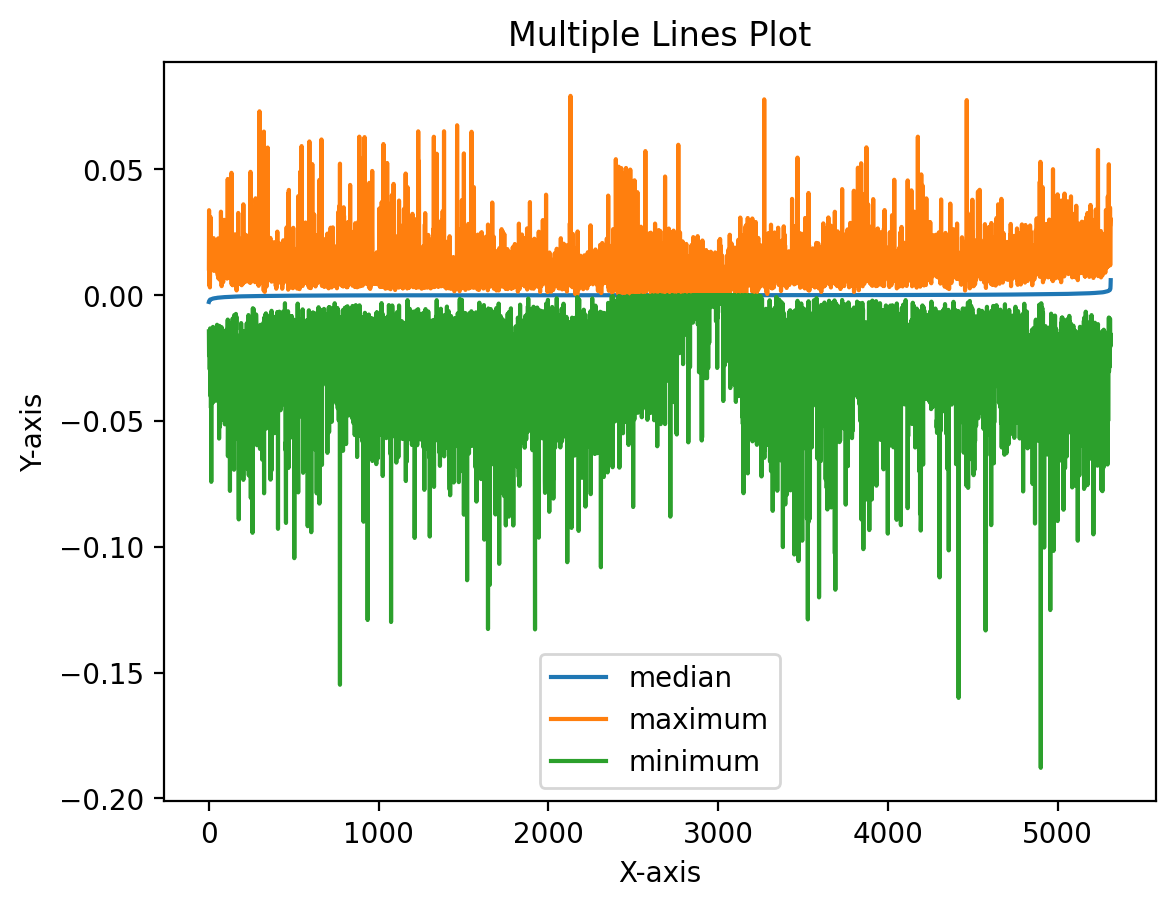

In [114]:
m_stats_df = colsum[['median', 'maximum', 'minimum', ]]#'maximum']]

m_stats_df_sorted = m_stats_df.sort_values('median').reset_index(drop=True)


for column in m_stats_df_sorted.columns:
    plt.plot(m_stats_df_sorted[column], label=column)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Multiple Lines Plot')
plt.legend()

# Show the plot
plt.show()

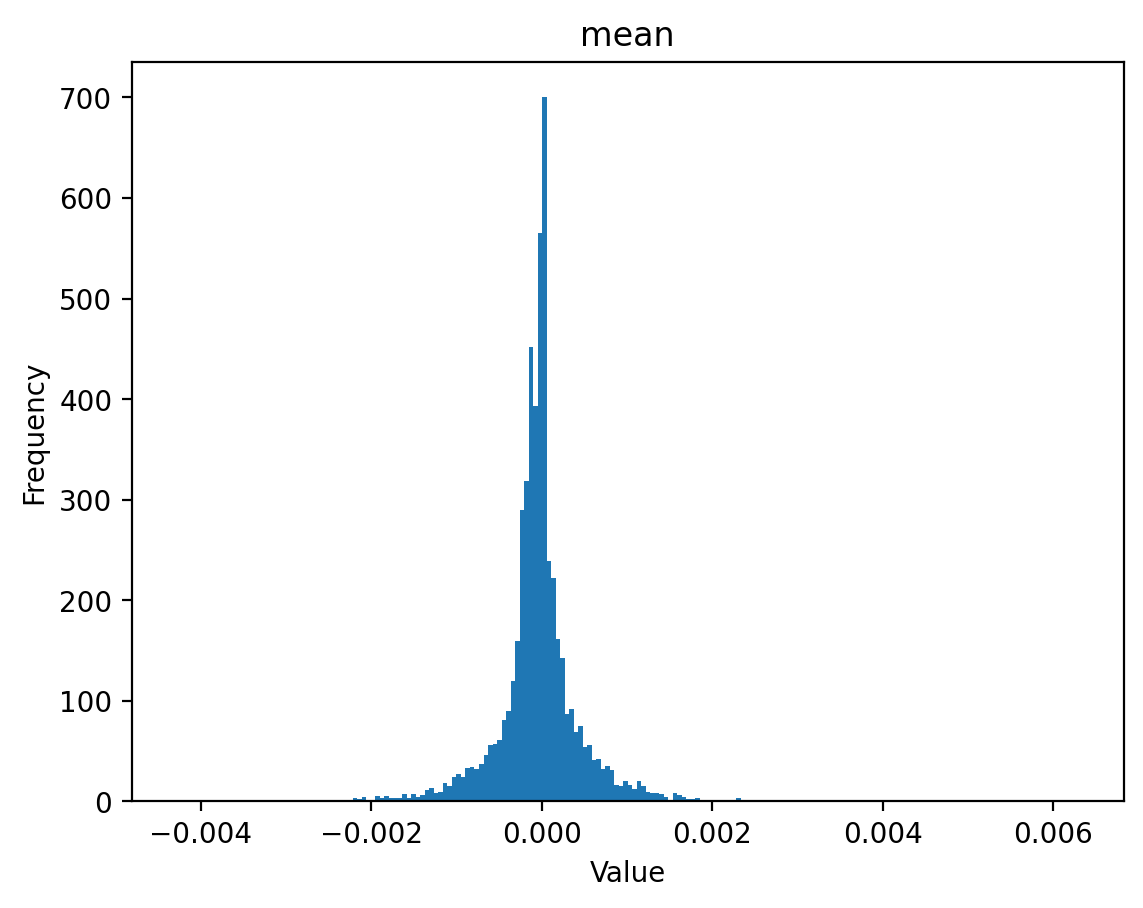

In [87]:
plot_hist(colsum['mean'].tolist(), 200, title="mean") 

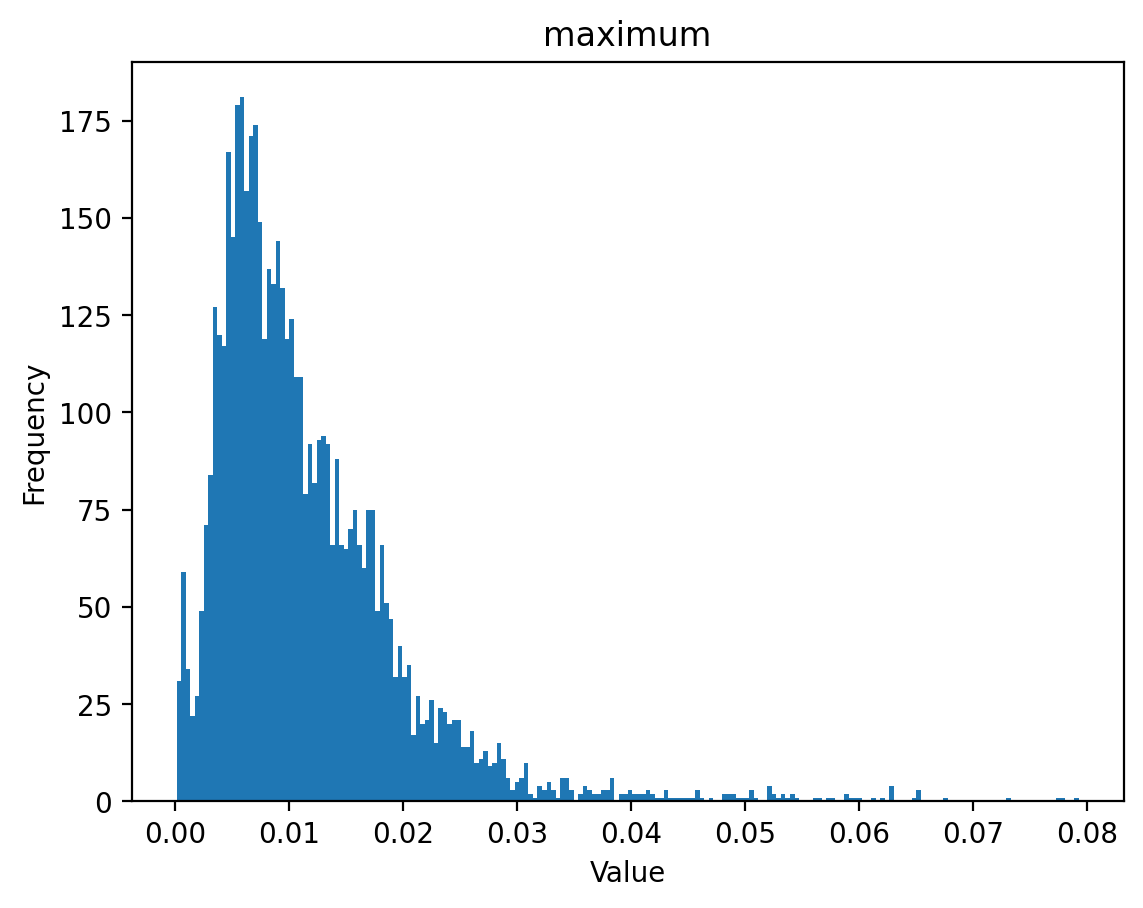

In [88]:
plot_hist(colsum['maximum'].tolist(), 200, title="maximum")

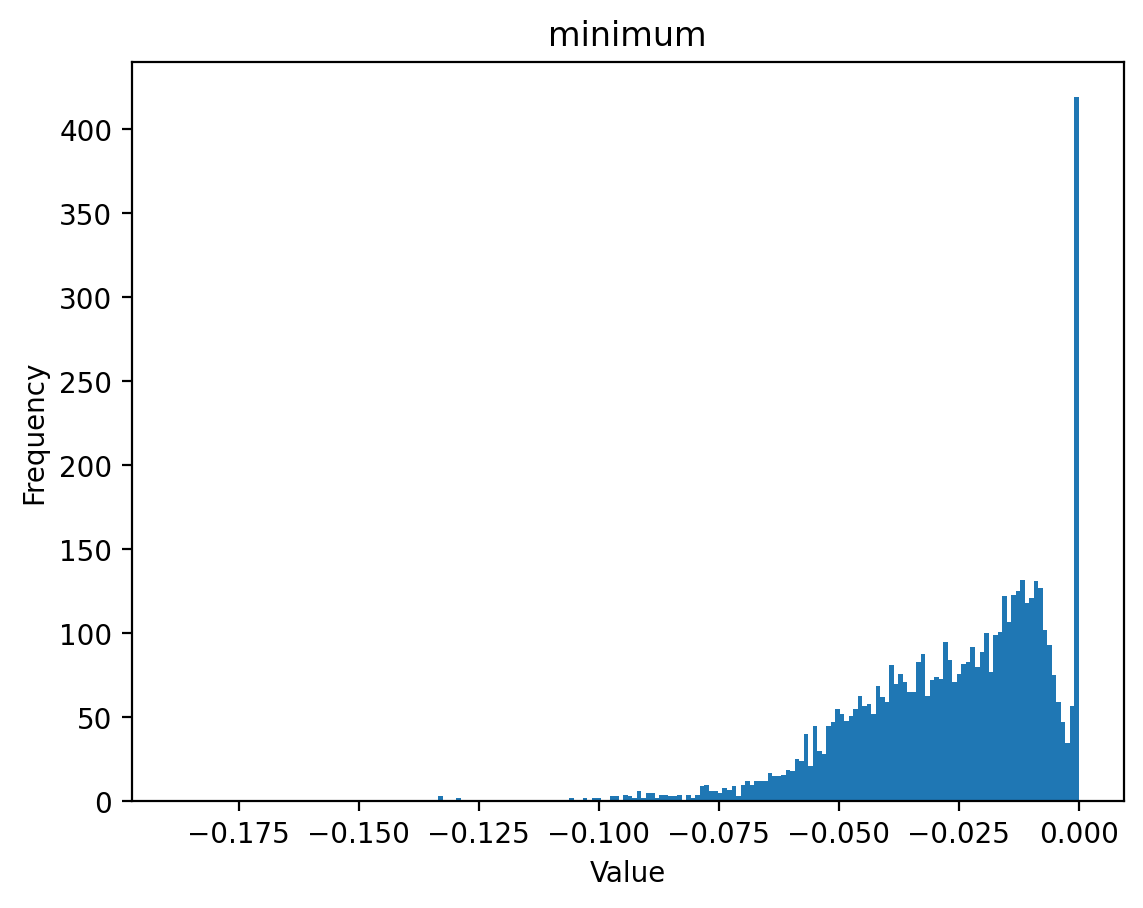

In [89]:
plot_hist(colsum['minimum'].tolist(), 200, title="minimum")

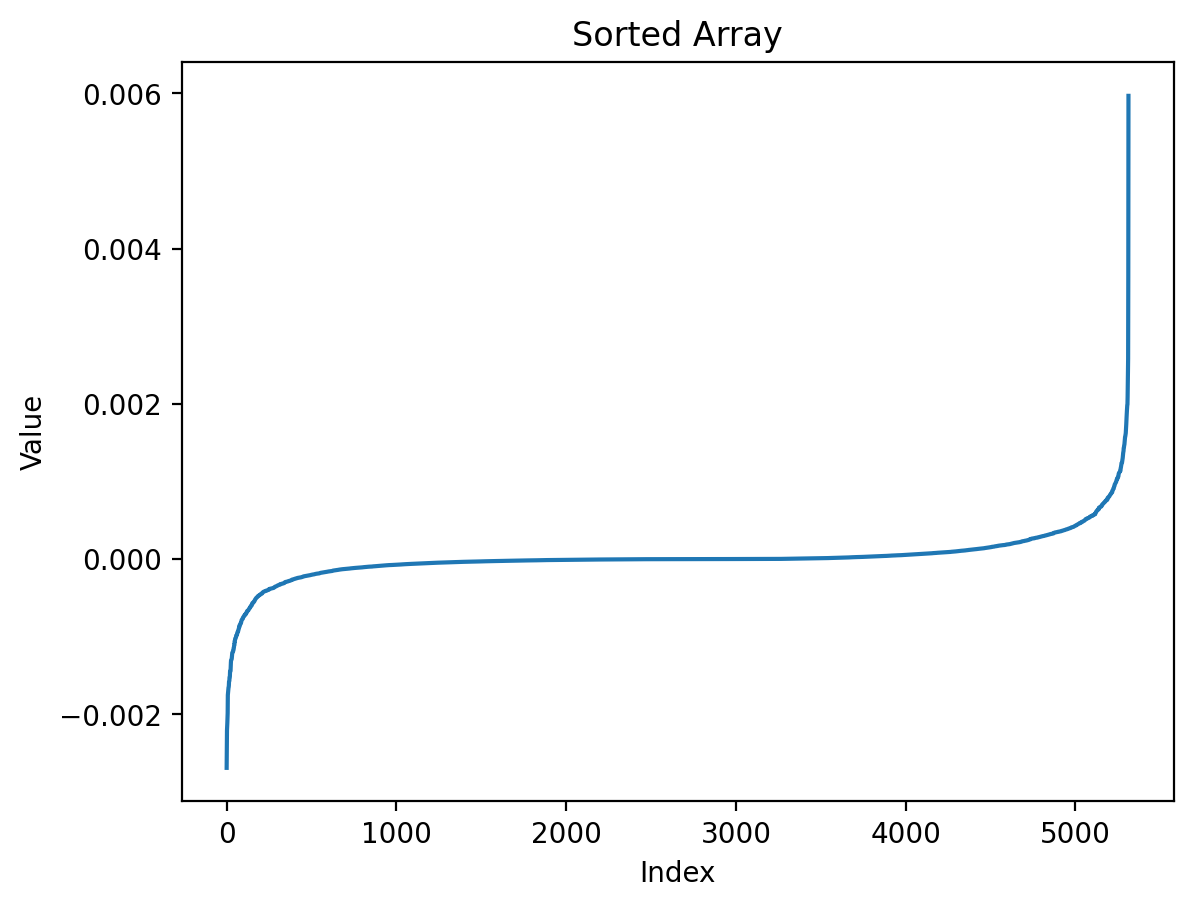

In [91]:
sorted_data = np.sort(colsum['median'].tolist())

# Plot the sorted array
plt.plot(sorted_data)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sorted Array')
plt.show()

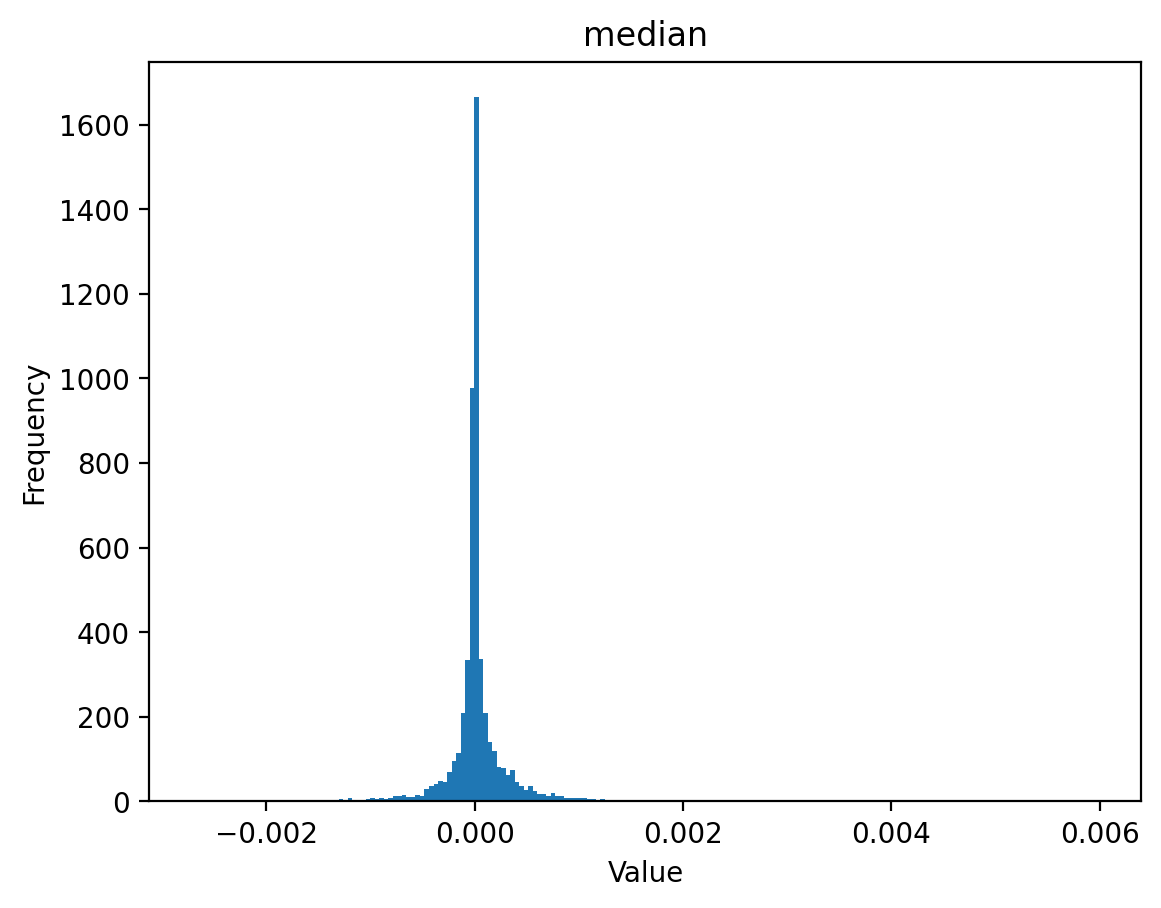

In [90]:
plot_hist(colsum['median'].tolist(), 200, title="median")

In [56]:
np.linspace(0.1, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

tolerance: 0.01, num outs: 15837, out percent: 0.0033267877309026378
tolerance: 0.01, num outs: 20408, out percent: 0.00428699147643247
tolerance: 0.01, num outs: 26592, out percent: 0.005586028877954344
tolerance: 0.01, num outs: 35247, out percent: 0.007404135073001533
tolerance: 0.01, num outs: 48007, out percent: 0.010084555067086123
tolerance: 0.0, num outs: 67384, out percent: 0.014154970288510661
tolerance: 0.0, num outs: 98803, out percent: 0.020754979363286817
tolerance: 0.0, num outs: 154096, out percent: 0.03237006264956575
tolerance: 0.0, num outs: 263000, out percent: 0.0552469011319943
tolerance: 0.0, num outs: 517985, out percent: 0.10881013719717136


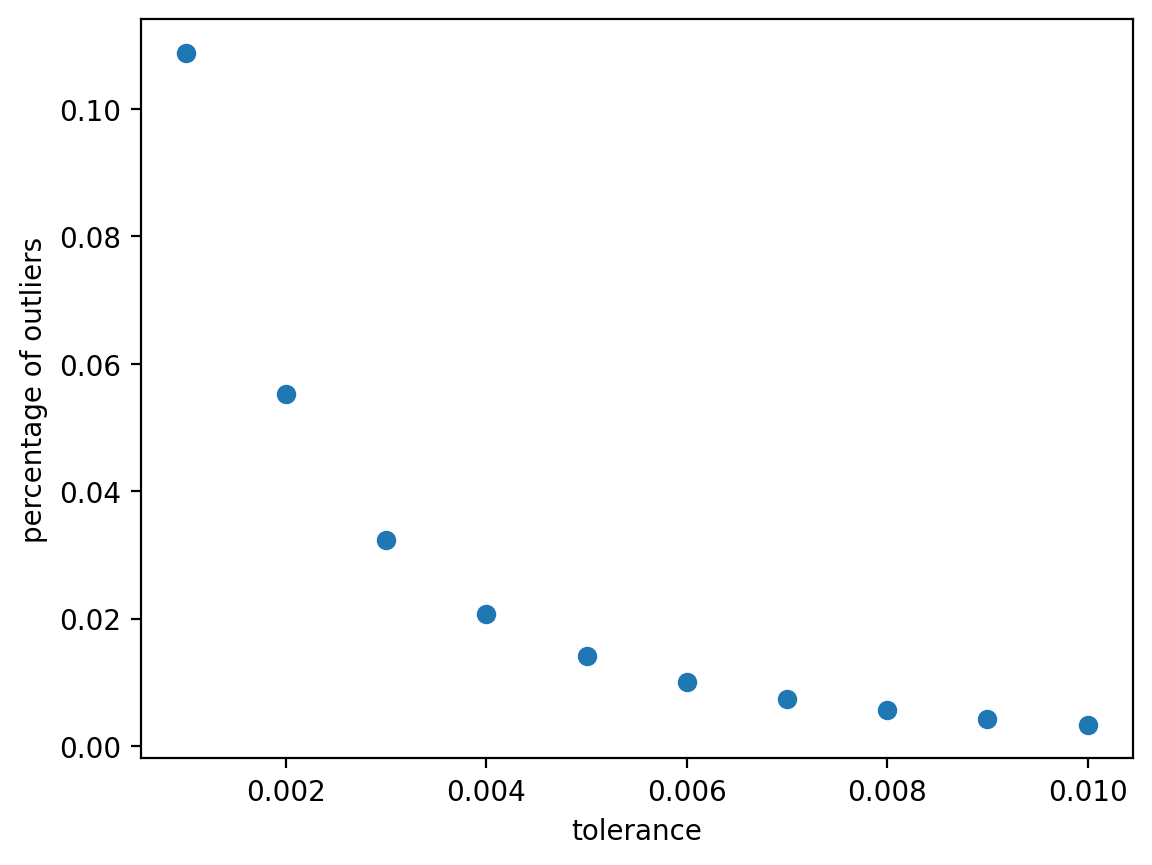

In [75]:
# plot tols to outs to find a good tolerance to use to determine outliers
# tolerance is the biggest difference that's acceptable
# if a difference is greater than the tolerance it'll be considered an outlier
plot_tols_vs_outs(relmax3, 0.001, 0.01, 10)

In [66]:
1/896

0.0011160714285714285

In [73]:
# get the indices for each outlier
all_inds, row_inds, col_inds = test.get_outlier_inds(relmax, 16)

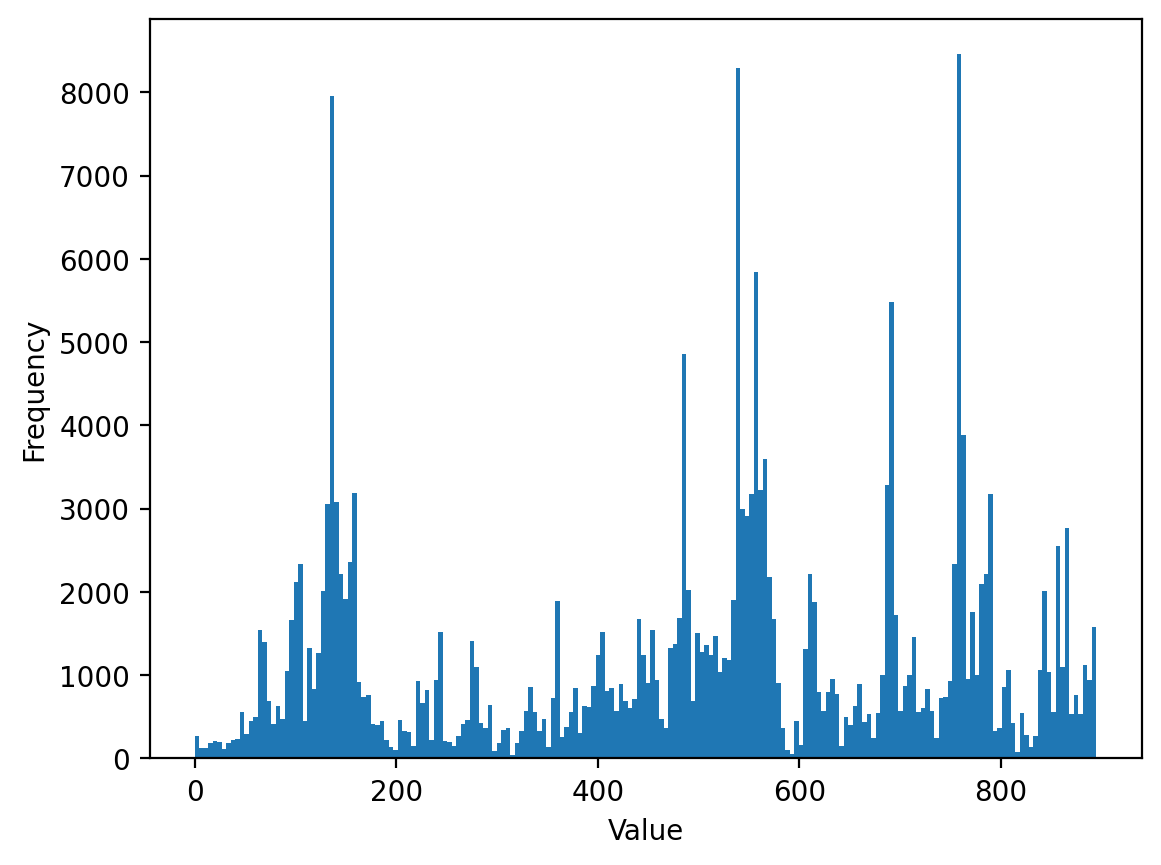

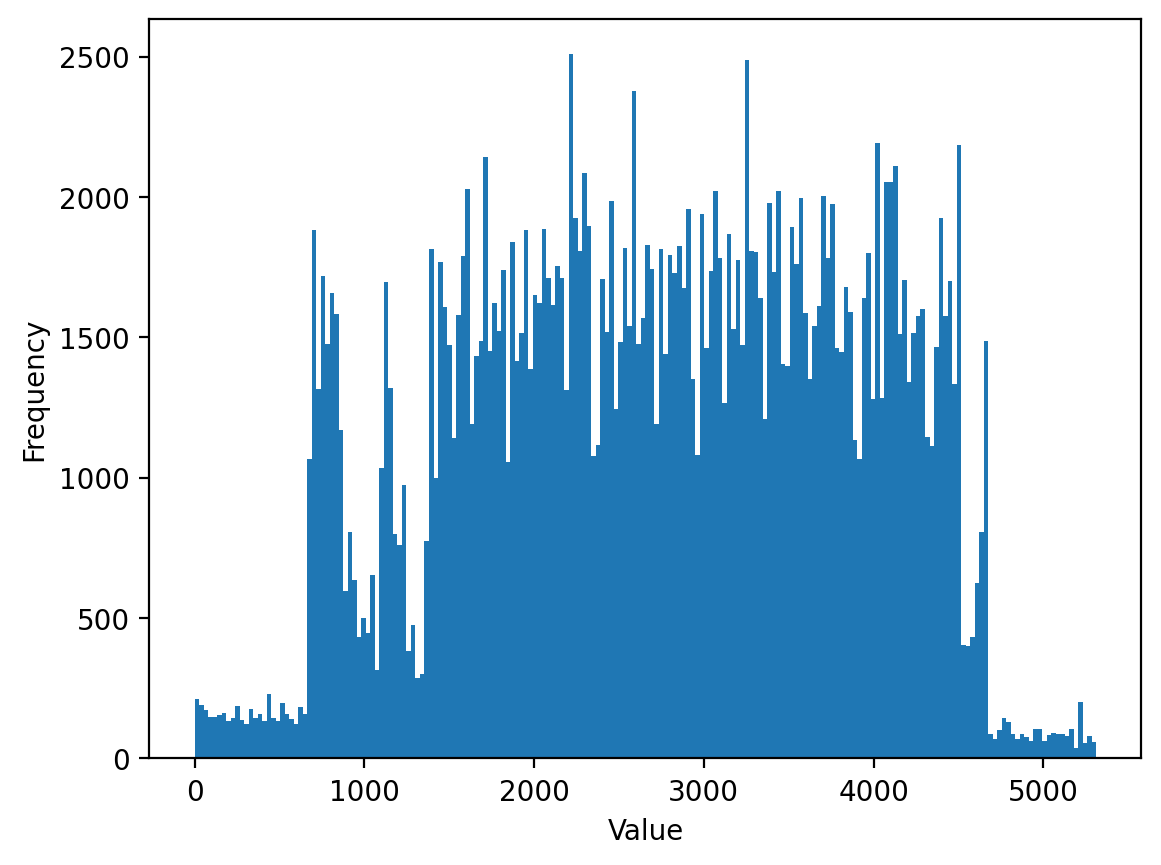

(None, None)

In [119]:
# plot histogram distribution of bins and tracks that have outliers
test.plot_hist(row_inds, 200), test.plot_hist(col_inds, 200)

In [121]:
# make df of info of outliers: track, bin#, difference, and slims
# organized by increasing difference
df_relmax_tol16 = test.make_outs_df(relmax, 16)
df_relmax_tol16

,name,bin,diff,system,cell,organ,developmental
4301,CHIP:PHB2:K562,158,16.000057,immune system,"cancer cell, leukocyte, hematopoietic cell","bodily fluid, blood",mesoderm
4380,CHIP:H3K27ac:trophoblast female embryo (40 weeks),772,16.000072,none,none,embryo,none
844,CHIP:SIRT6:K562,806,16.000170,immune system,"cancer cell, leukocyte, hematopoietic cell","bodily fluid, blood",mesoderm
4055,CHIP:H2BK20ac:H9,848,16.000177,none,"embryonic cell, stem cell",embryo,none
2255,CHIP:H2BK120ac:H9,153,16.000206,none,"embryonic cell, stem cell",embryo,none
...,...,...,...,...,...,...,...
4706,"CAGE:medulla oblongata, adult, pool1",563,100.000000,NaN,NaN,NaN,NaN
4705,"CAGE:nucleus accumbens, adult, pool1",563,100.000000,NaN,NaN,NaN,NaN
4704,"CAGE:occipital pole, adult, pool1",563,100.000000,NaN,NaN,NaN,NaN
3882,CHIP:H3K36me3:amnion male embryo (16 weeks),760,100.000000,reproductive system,none,"extraembryonic component, placenta",mesoderm


In [89]:
df_relmax_tol16[5:15]

,name,bin,diff,system,cell,organ,developmental
4068,CHIP:3xFLAG-PBX2:HepG2 genetically modified us...,157,16.000284,"endocrine system, exocrine system, digestive s...","cancer cell, epithelial cell","epithelium, endocrine gland, exocrine gland, l...",endoderm
3103,CHIP:H3F3A:NCI-H929,3,16.000452,"immune system, skeletal system","cancer cell, B cell, leukocyte, hematopoietic ...","bone marrow, bone element",mesoderm
1747,CHIP:EZH2phosphoT487:GM23248,160,16.000462,integumental system,"fibroblast, connective tissue cell","skin of body, limb, connective tissue",ectoderm
3249,CHIP:H3K36me3:A673,358,16.000467,musculature,cancer cell,musculature of body,mesoderm
4643,"CHIP:GR:ChIP-seq, GR_HighDensity_DMI / hMSC / ...",577,16.000479,NaN,NaN,NaN,NaN
4523,CHIP:.:batch1_chrom1_LoVo_CEBPG_Rabbit_PassedQ...,570,16.000492,NaN,NaN,NaN,NaN
1823,"CHIP:H3K9me3:CD4-positive, alpha-beta memory T...",339,16.000494,immune system,"CD4+ T cell, hematopoietic cell, T cell, leuko...","bodily fluid, blood",none
2301,CHIP:H3K27me3:liver male adult (78 years),683,16.000582,"endocrine system, exocrine system, digestive s...",none,"exocrine gland, endocrine gland, liver",endoderm
3756,CHIP:NFXL1:GM12878,802,16.000587,immune system,"hematopoietic cell, B cell, leukocyte","bodily fluid, blood",mesoderm
4305,CHIP:H3K36me3:H1-hESC,518,16.000599,none,"embryonic cell, stem cell",embryo,none


In [90]:
relmax16sys_packed = df_relmax_tol16['system_slims'].tolist()
relmax16sys = []
for sys in relmax16sys_packed:
    if type(sys) == float:
        continue
    sys_list = sys.split(", ")
    relmax16sys += sys_list

relmax16sys

['immune system',
 'none',
 'immune system',
 'none',
 'none',
 'endocrine system',
 'exocrine system',
 'digestive system',
 'immune system',
 'skeletal system',
 'integumental system',
 'musculature',
 'immune system',
 'endocrine system',
 'exocrine system',
 'digestive system',
 'immune system',
 'none',
 'endocrine system',
 'exocrine system',
 'digestive system',
 'exocrine system',
 'integumental system',
 'endocrine system',
 'exocrine system',
 'digestive system',
 'none',
 'skeletal system',
 'digestive system',
 'reproductive system',
 'excretory system',
 'respiratory system',
 'none',
 'central nervous system',
 'musculature',
 'none',
 'immune system',
 'none',
 'exocrine system',
 'integumental system',
 'immune system',
 'endocrine system',
 'immune system',
 'skeletal system',
 'reproductive system',
 'reproductive system',
 'integumental system',
 'excretory system',
 'digestive system',
 'reproductive system',
 'central nervous system',
 'peripheral nervous system',


In [93]:
sys_counts = Counter(relmax16sys)
sorted_sys_counts = dict(sorted(sys_counts.items(), key=lambda item: item[1], reverse=True))

sorted_sys_counts

{'immune system': 70041,
 'digestive system': 32201,
 'none': 26820,
 'exocrine system': 19766,
 'central nervous system': 18958,
 'integumental system': 18874,
 'endocrine system': 18808,
 'reproductive system': 17530,
 'musculature': 11953,
 'excretory system': 10607,
 'respiratory system': 8971,
 'circulatory system': 8123,
 'skeletal system': 7019,
 'peripheral nervous system': 1823,
 'sensory system': 95}

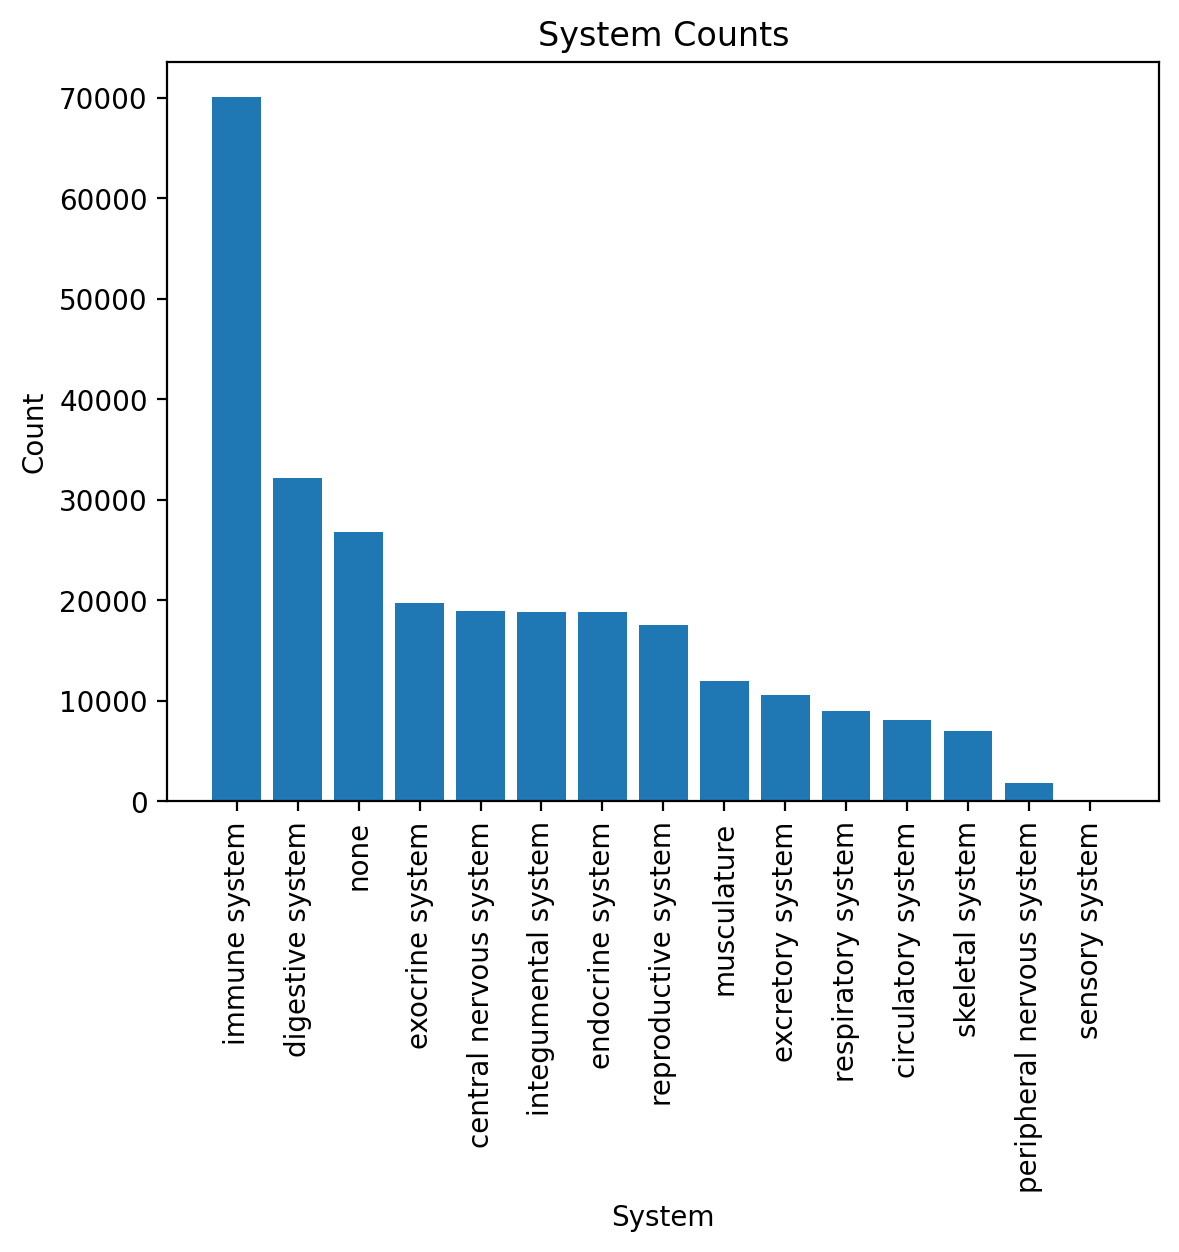

In [94]:
keys = sorted_sys_counts.keys()
values = sorted_sys_counts.values()

# Create a bar plot
plt.bar(keys, values)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('System')
plt.ylabel('Count')
plt.title('System Counts')

plt.show()

In [72]:
len(test.get_outliers(relmax, 16)) / 5313 / 896

0.04819357337796779

tolerance: 100, num outs: 0, out percent: 0.0
tolerance: 89, num outs: 7912, out percent: 0.0016620284477427334
tolerance: 78, num outs: 11997, out percent: 0.002520140961522949
tolerance: 67, num outs: 18194, out percent: 0.0038219091984619934
tolerance: 56, num outs: 27914, out percent: 0.00586373383345433
tolerance: 45, num outs: 44080, out percent: 0.009259632706837675
tolerance: 34, num outs: 73402, out percent: 0.015419137022397892
tolerance: 23, num outs: 137315, out percent: 0.028844974254523943
tolerance: 12, num outs: 332400, out percent: 0.0698253609744293
tolerance: 1, num outs: 2148076, out percent: 0.4512340015057406


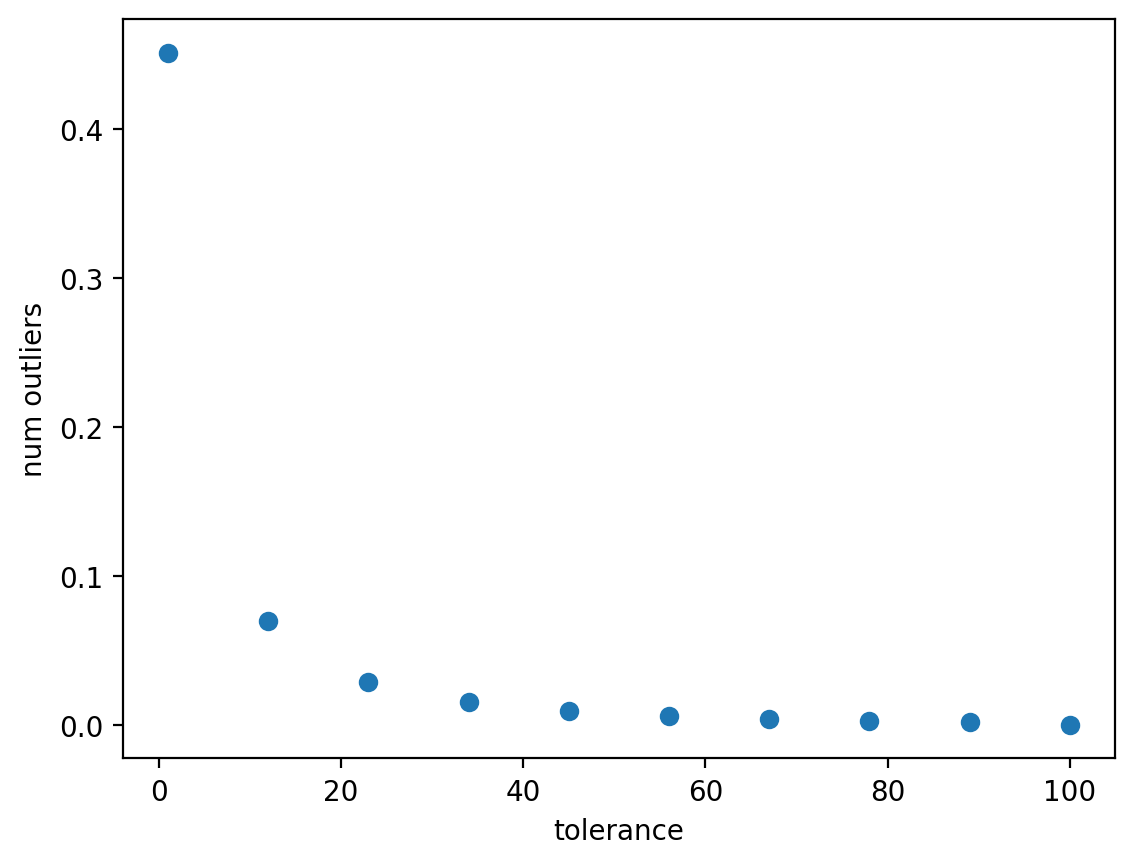

In [69]:
test.plot_tol_vs_outs(relmax, 1, 100, 10)

In [ ]:
# get_summary(self, arr):
# def get_outliers(self, arr, tol):
# def get_outlier_inds(self, arr, tol):
# def plot_hist(self, arr, bin_num):
# def plot_tol_vs_outs(self, arr, mintol, maxtol, steps):
# def make_df(self, arr, tol):

## finding out if the same columns 

## Run Predictions

We'll pick one individual at random.

In [85]:
# rand_individual = np.random.choice(a=geuvadis_gene_expression.columns[6:-1], replace=False) # individuals we are interested in
rand_individual = 'NA12413'

'NA12413'

In [107]:
gene = 'GSDMB'
gene_interval = gene_intervals[gene]
target_interval = kipoiseq.Interval("chr" + gene_interval[0],
                                        gene_interval[1],
                                        gene_interval[2])
target_fa = fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH))
window_coords = target_interval.resize(SEQUENCE_LENGTH)
cur_gene_vars = pd.read_csv("/grand/TFXcan/imlab/users/lvairus/hackenf/data/individual_beds/chr" + gene_interval[0] + "/chr" + gene_interval[0] + "_"+ gene + ".bed", sep="\t", header=0) # read in the appropriate bed file for the gene


In [108]:
haplo_1, haplo_2 = geno_to_seq(gene, rand_individual)

haplo_1_enc = one_hot_encode("".join(haplo_1))[np.newaxis]
haplo_2_enc = one_hot_encode("".join(haplo_2))[np.newaxis]
average_enc = np.add(haplo_1_enc, haplo_2_enc) / 2

In [109]:
prediction_1 = model.predict_on_batch(haplo_1_enc)['human'][0]
prediction_2 = model.predict_on_batch(haplo_2_enc)['human'][0]

post_average = (prediction_1 + prediction_2) / 2
pre_average = model.predict_on_batch(average_enc)['human'][0]

## Comparing Predictions

In [113]:
pre_average2, post_average2 = run_predictions2(gene, '17', rand_individual)

Currently on gene GSDMB, and predicting on individual NA12413...


In [110]:
diff = pre_average - post_average

abs_diff = np.sqrt(np.square(diff))

rel_diff = (abs_diff) / ((pre_average + post_average) + 10**-16)

In [111]:
# Summary Statistics of Absolute Differece
arr = abs_diff

print("Mean:", np.mean(arr))
print("Median:", np.median(arr))
print("Standard Deviation:", np.std(arr))
print("Minimum:", np.min(arr))
print("Maximum:", np.max(arr))
print("Sum:", np.sum(arr))

Mean: 0.011741725
Median: 0.0024814606
Standard Deviation: 0.06555718
Minimum: 0.0
Maximum: 10.2612915
Sum: 55895.87


In [91]:
# Summary Statistics of Relative Difference
arr = rel_diff

print("Mean:", np.mean(arr))
print("Median:", np.median(arr))
print("Standard Deviation:", np.std(arr))
print("Minimum:", np.min(arr))
print("Maximum:", np.max(arr))
print("Sum:", np.sum(arr))

Mean: 0.00026652514
Median: 8.4674466e-05
Standard Deviation: 0.0011749842
Minimum: 0.0
Maximum: 0.24099354
Sum: 1268.779


In [92]:
bigDiff = abs_diff[abs_diff>1]
len(bigDiff)

72

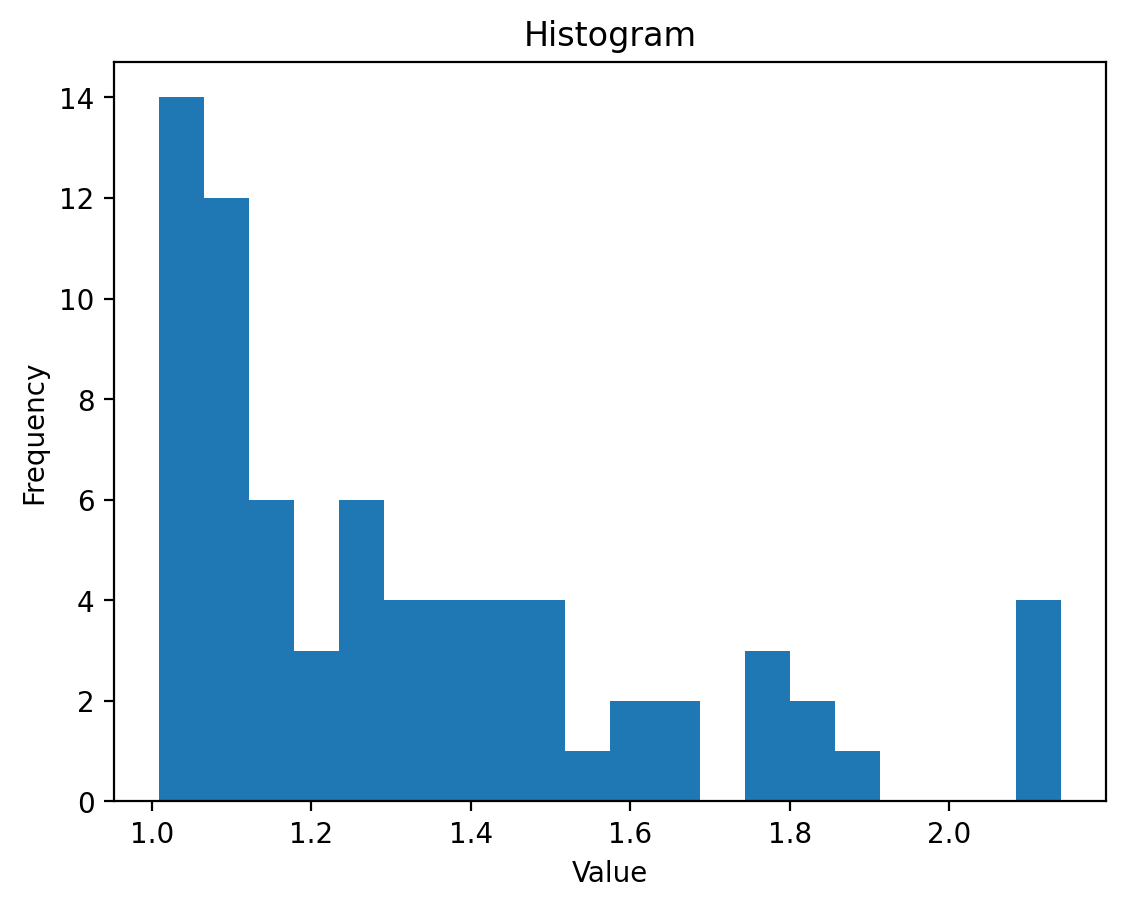

In [93]:
# Plot the histogram
plt.hist(bigDiff, bins=20)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Display the plot
plt.show()

## In which tracks is it not precise?

In [94]:
# max diff tolerance is 1. If a diff is greater than 1 we will count it as too big
tolerance = 1

indices = np.where(abs_diff > tolerance)
indices[0][0], indices[1][0]

ind_of_big_diffs = np.array(list(zip(indices[0], indices[1])))
len(ind_of_big_diffs), ind_of_big_diffs

(72,
 array([[ 773, 4740],
        [ 773, 4746],
        [ 773, 4747],
        [ 773, 4748],
        [ 773, 4754],
        [ 773, 4759],
        [ 773, 4760],
        [ 773, 4764],
        [ 773, 4766],
        [ 773, 4770],
        [ 773, 4777],
        [ 773, 4782],
        [ 773, 4797],
        [ 773, 4808],
        [ 773, 4810],
        [ 773, 4815],
        [ 773, 4816],
        [ 773, 4817],
        [ 773, 4818],
        [ 773, 4819],
        [ 773, 4868],
        [ 773, 4869],
        [ 773, 4870],
        [ 773, 4874],
        [ 773, 4877],
        [ 773, 4879],
        [ 773, 4881],
        [ 773, 4884],
        [ 773, 4885],
        [ 773, 4886],
        [ 773, 4887],
        [ 773, 4890],
        [ 773, 4892],
        [ 773, 4893],
        [ 773, 4897],
        [ 773, 4898],
        [ 773, 4900],
        [ 773, 4902],
        [ 773, 4905],
        [ 773, 4906],
        [ 773, 4909],
        [ 773, 4920],
        [ 773, 5056],
        [ 773, 5057],
        [ 773, 5072],
     

### cols

In [95]:
# all the indices of the columns where the diff exceeds tolerance
col_inds = indices[1]

In [96]:
counts = Counter(col_inds)
[(key,value) for key,value in counts.items() if value > 8]

[]

In [97]:
print(f"Number of unique col ind: {len(set(col_inds))} \nTotal col ind: {len(col_inds)}")

Number of unique col ind: 72 
Total col ind: 72


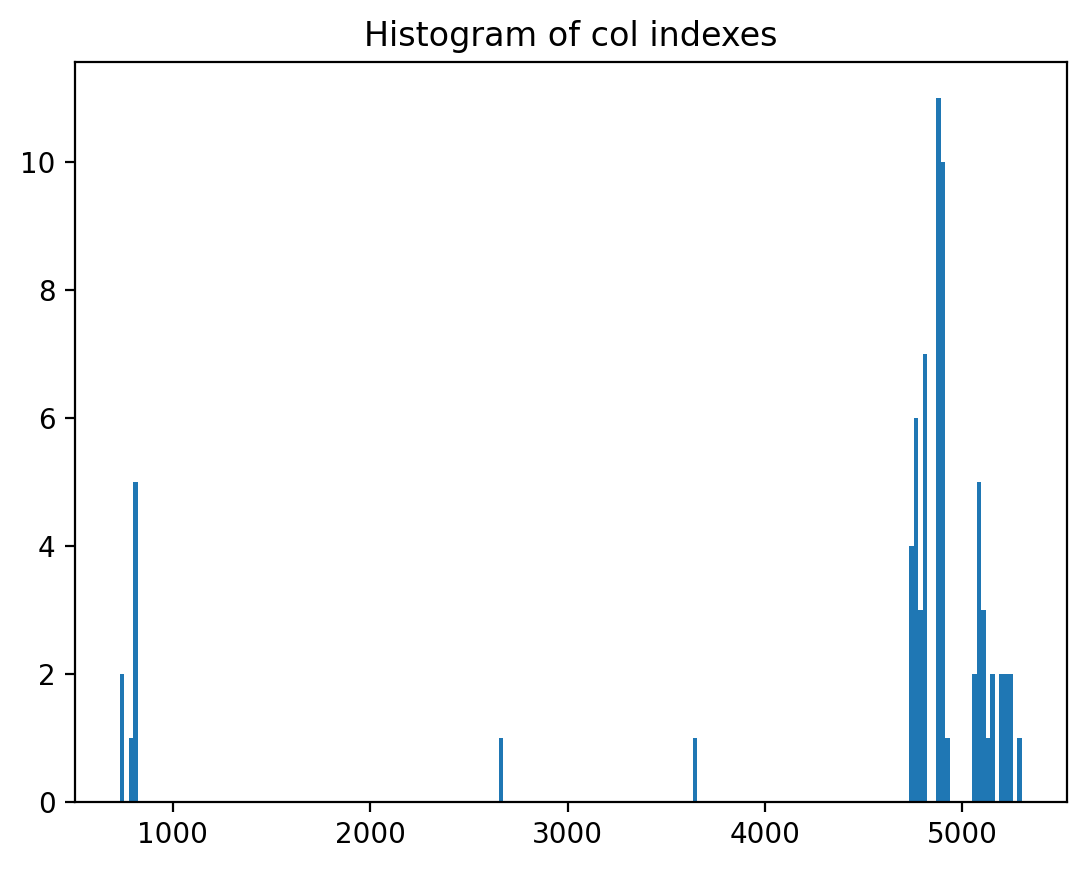

In [98]:
plt.hist(col_inds, bins=200)  # Specify the number of bins
plt.title('Histogram of col indexes')
plt.show()

Analysis: 
the difference exceeds the tolerance in 227 unique columns that are pretty evenly distributed, so enformer doesn't necessarily do better or worse with averaging before/after in any particular cell line

i want to get the amount of times it affects each col
227 uniqe cols

### rows

In [99]:
len(set(indices[0])), len(indices[0])

(3, 72)

In [100]:
# Summary Statistics of rows
arr1 = indices[0]

print("Mean:", np.mean(arr1))
print("Median:", np.median(arr1))
print("Standard Deviation:", np.std(arr1))
print("Minimum:", np.min(arr1))
print("Maximum:", np.max(arr1))
print("Sum:", np.sum(arr1))

q1 = np.percentile(arr, 25)
q3 = np.percentile(arr, 75)
iqr = q3 - q1

print("Q1:", q1)
print("Q3:", q3)
print("Interquartile Range:", iqr)

Mean: 780.9027777777778
Median: 773.0
Standard Deviation: 19.678075590631757
Minimum: 773
Maximum: 830
Sum: 56225


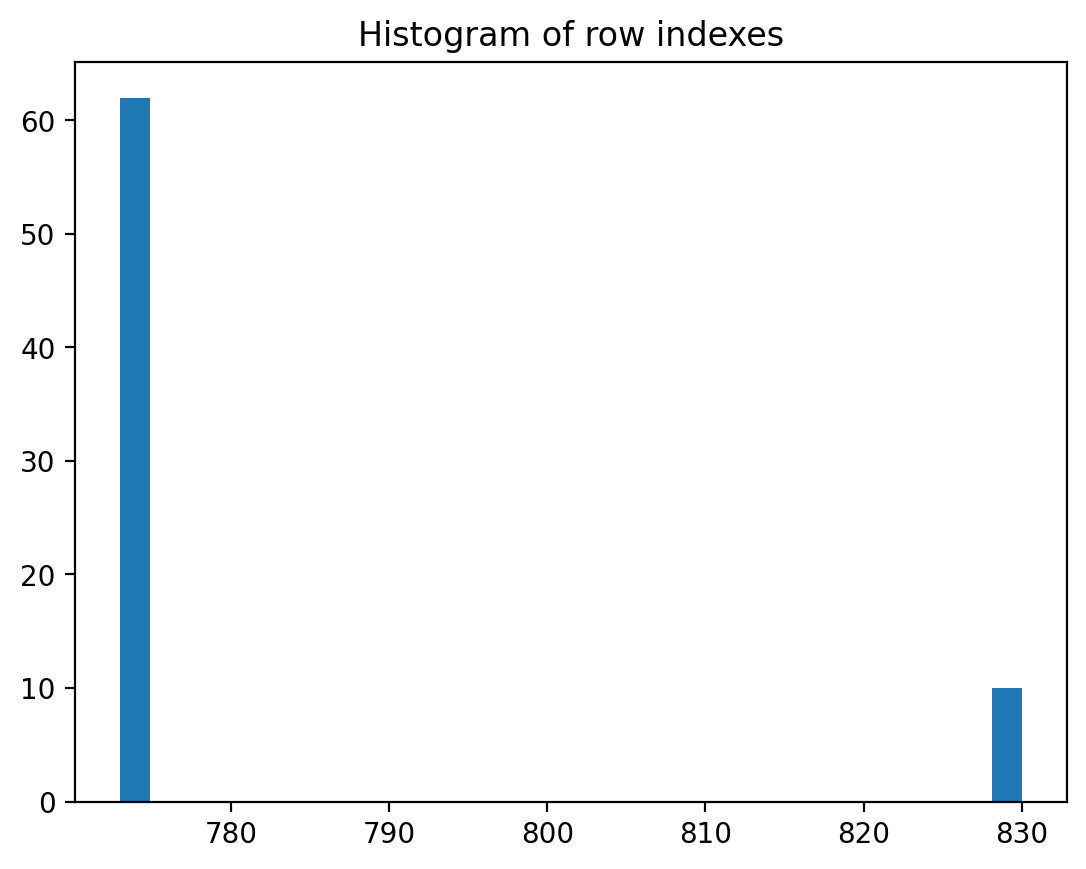

In [101]:
plt.hist(indices[0], bins=30)  # Specify the number of bins
plt.title('Histogram of row indexes')
plt.show()

Analysis:
There are only a few specific locations where enformer does worse 

## Comparing across tracks

In [102]:
res = []
for i in range(5313):
    pre_track = pre_average[:, i]
    post_track = post_average[:, i]
    corr = np.corrcoef(pre_track, post_track)[0][1]
    res.append(corr)


The results from both methods are nearly identical.

In [103]:
print(min(res), max(res))

0.9989958894392978 0.9999999912865261
